In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# add the SVM module
from sklearn import svm

import random
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()   
        
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# Testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

## Testing Support Vector Machine (SVM) algorithms

### MODEL: Linear SVR
##### Train data

In [5]:
linear_SVR = svm.LinearSVR()
linear_SVR.fit(X_train, y_train)

linear_SVR_performance_train = BinaryClassificationPerformance(linear_SVR.predict(X_train), y_train, 'linear_SVR_train_default')
linear_SVR_performance_train.compute_measures()
print(linear_SVR_performance_train.performance_measures)



{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_train_default'}


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/assignments/01_movie_reviews/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### MODEL: Linear SVR
##### Test data

In [6]:
linear_SVR_performance_test = BinaryClassificationPerformance(linear_SVR.predict(X_test), y_test, 'linear_SVR_test_default')
linear_SVR_performance_test.compute_measures()
print(linear_SVR_performance_test.performance_measures)



{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_test_default'}


## Linear SVR
#### max_iter=1,000,000

In [7]:
linear_SVR_1m = svm.LinearSVR(max_iter=1000000)
linear_SVR_1m.fit(X_train, y_train)

linear_SVR_1m_performance_train = BinaryClassificationPerformance(linear_SVR_1m.predict(X_train), y_train, 
                                                                  'linear_SVR_1m_train')
linear_SVR_1m_performance_train.compute_measures()
print(linear_SVR_1m_performance_train.performance_measures)



{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_1m_train'}


##### Test data

In [8]:
linear_SVR_1m_performance_test = BinaryClassificationPerformance(linear_SVR_1m.predict(X_test), y_test, 
                                                              'linear_SVR_1m_test')
linear_SVR_1m_performance_test.compute_measures()
print(linear_SVR_1m_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_1m_test'}


## Linear SVR
#### max_iter=1,000,000,000

In [9]:
linear_SVR_1b = svm.LinearSVR(max_iter=1000000000)
linear_SVR_1b.fit(X_train, y_train)

linear_SVR_1b_performance_train = BinaryClassificationPerformance(linear_SVR_1b.predict(X_train), y_train, 
                                                                  'linear_SVR_1b_train')
linear_SVR_1b_performance_train.compute_measures()
print(linear_SVR_1b_performance_train.performance_measures)



{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_1b_train'}


##### Test data

In [10]:
linear_SVR_1b_performance_test = BinaryClassificationPerformance(linear_SVR_1b.predict(X_test), y_test, 
                                                              'linear_SVR_1b_test')
linear_SVR_1b_performance_test.compute_measures()
print(linear_SVR_1b_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_1b_test'}


## Linear SVR
#### C=0.0001

In [11]:
linear_SVR_C_0001 = svm.LinearSVR(C=0.0001)
linear_SVR_C_0001.fit(X_train, y_train)

linear_SVR_C_0001_performance_train = BinaryClassificationPerformance(linear_SVR_C_0001.predict(X_train), y_train, 
                                                                  'linear_SVR_C_0001_train')
linear_SVR_C_0001_performance_train.compute_measures()
print(linear_SVR_C_0001_performance_train.performance_measures)



{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_C_0001_train'}


##### Test data

In [12]:
linear_SVR_C_0001_performance_test = BinaryClassificationPerformance(linear_SVR_C_0001.predict(X_test), y_test, 
                                                              'linear_SVR_C_0001_test')
linear_SVR_C_0001_performance_test.compute_measures()
print(linear_SVR_C_0001_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0, 'Accuracy': 0.0, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVR_C_0001_test'}


# Linear SVC

### MODEL: LinearSVC
##### Train data

In [13]:
linear_SVC = svm.LinearSVC()
linear_SVC.fit(X_train, y_train)

linear_SVC_performance_train = BinaryClassificationPerformance(linear_SVC.predict(X_train), y_train, 
                                                               'linear_SVC_default')
linear_SVC_performance_train.compute_measures()
print(linear_SVC_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_default'}


### MODEL: LinearSVC
##### Test data

In [14]:
linear_SVC_performance_test = BinaryClassificationPerformance(linear_SVC.predict(X_test), y_test, 
                                                              'linear_SVC_test_default')
linear_SVC_performance_test.compute_measures()
print(linear_SVC_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_test_default'}


# MODEL: LinearSVC

## TRAIN SET - Iterations

## Default: Train set
###### C=1.0

In [15]:
linear_SVC_default = svm.LinearSVC()
linear_SVC_default.fit(X_train, y_train)

linear_SVC_default_performance_train = BinaryClassificationPerformance(linear_SVC_default.predict(X_train), y_train, 
                                                               'linear_SVC_default_train')
linear_SVC_default_performance_train.compute_measures()
print(linear_SVC_default_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_default_train'}


## Iteration 1: Train set
###### C=100

In [16]:
linear_SVC_100 = svm.LinearSVC(C=100)
linear_SVC_100.fit(X_train, y_train)

linear_SVC_100_performance_train = BinaryClassificationPerformance(linear_SVC_100.predict(X_train), y_train, 
                                                               'linear_SVC_100_train')
linear_SVC_100_performance_train.compute_measures()
print(linear_SVC_100_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_100_train'}


## Iteration 2: Train set
###### C=1,000,000

In [17]:
linear_SVC_1m = svm.LinearSVC(C=1000000)
linear_SVC_1m.fit(X_train, y_train)

linear_SVC_1m_performance_train = BinaryClassificationPerformance(linear_SVC_1m.predict(X_train), y_train, 
                                                               'linear_SVC_1m_train')
linear_SVC_1m_performance_train.compute_measures()
print(linear_SVC_1m_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_1m_train'}


## Iteration 3: Train set
###### C=0.001

In [18]:
linear_SVC_001 = svm.LinearSVC(C=0.001)
linear_SVC_001.fit(X_train, y_train)

linear_SVC_001_performance_train = BinaryClassificationPerformance(linear_SVC_001.predict(X_train), y_train, 
                                                               'linear_SVC_001_train')
linear_SVC_001_performance_train.compute_measures()
print(linear_SVC_001_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_001_train'}


## Iteration 4: Train set
###### C=1e-15

In [19]:
linear_SVC_1e15 = svm.LinearSVC(C=1e-15)
linear_SVC_1e15.fit(X_train, y_train)

linear_SVC_1e15_performance_train = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_train), y_train, 
                                                               'linear_SVC_1e15_train')
linear_SVC_1e15_performance_train.compute_measures()
print(linear_SVC_1e15_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8567, 'TN': 9817, 'FP': 206, 'FN': 1410, 'Accuracy': 0.9192, 'Precision': 0.9765188646985068, 'Recall': 0.8586749523904982, 'desc': 'linear_SVC_1e15_train'}


## Iteration 5: Train set
###### C=1e-323

In [20]:
linear_SVC_1e323 = svm.LinearSVC(C=1e-323)
linear_SVC_1e323.fit(X_train, y_train)

linear_SVC_1e323_performance_train = BinaryClassificationPerformance(linear_SVC_1e323.predict(X_train), y_train, 
                                                               'linear_SVC_1e323_train')
linear_SVC_1e323_performance_train.compute_measures()
print(linear_SVC_1e323_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 10023, 'FP': 0, 'FN': 9977, 'Accuracy': 0.50115, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVC_1e323_train'}


## TEST SET - Iterations

## Default: Test set
###### C=1.0

In [21]:
linear_SVC_default_performance_test = BinaryClassificationPerformance(linear_SVC_default.predict(X_test), y_test, 
                                                              'linear_SVC_default_test')
linear_SVC_default_performance_test.compute_measures()
print(linear_SVC_default_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_default_test'}


## Iteration 1: Test set
###### C=100

In [22]:
linear_SVC_100_performance_test = BinaryClassificationPerformance(linear_SVC_100.predict(X_test), y_test, 
                                                              'linear_SVC_100_test')
linear_SVC_100_performance_test.compute_measures()
print(linear_SVC_100_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_100_test'}


## Iteration 2: Test set
###### C=1,000,000

In [23]:
linear_SVC_1m_performance_test = BinaryClassificationPerformance(linear_SVC_1m.predict(X_test), y_test, 
                                                              'linear_SVC_1m_test')
linear_SVC_1m_performance_test.compute_measures()
print(linear_SVC_1m_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_1m_test'}


## Iteration 3: Test set
###### C=0.001

In [24]:
linear_SVC_001_performance_test = BinaryClassificationPerformance(linear_SVC_001.predict(X_test), y_test, 
                                                              'linear_SVC_001_test')
linear_SVC_001_performance_test.compute_measures()
print(linear_SVC_001_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2218, 'TN': 2115, 'FP': 362, 'FN': 305, 'Accuracy': 0.8666, 'Precision': 0.8596899224806202, 'Recall': 0.8791121680539041, 'desc': 'linear_SVC_001_test'}


## Iteration 4: Test set
###### C=1e-15

In [25]:
linear_SVC_1e15_performance_test = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_test), y_test, 
                                                              'linear_SVC_1e15_test')
linear_SVC_1e15_performance_test.compute_measures()
print(linear_SVC_1e15_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1878, 'TN': 2311, 'FP': 166, 'FN': 645, 'Accuracy': 0.8378, 'Precision': 0.9187866927592955, 'Recall': 0.7443519619500595, 'desc': 'linear_SVC_1e15_test'}


## Iteration 5: Test set
###### C=1e-323

In [26]:
linear_SVC_1e323_performance_test = BinaryClassificationPerformance(linear_SVC_1e323.predict(X_test), y_test, 
                                                              'linear_SVC_1e323_test')
linear_SVC_1e323_performance_test.compute_measures()
print(linear_SVC_1e323_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 2477, 'FP': 0, 'FN': 2523, 'Accuracy': 0.4954, 'Precision': nan, 'Recall': 0.0, 'desc': 'linear_SVC_1e323_test'}


# MODEL: SVC
#### C=1e-15

## TRAIN SET


In [27]:
# worked with such a small number as the smaller the C value, the faster the model is trained

SVC_1e_15 = svm.SVC(C=1e-15, kernel='linear')
SVC_1e_15.fit(X_train, y_train)

SVC_performance_train_1e_15 = BinaryClassificationPerformance(SVC_1e_15.predict(X_train), y_train, 'SVC_1e-15_train')
SVC_performance_train_1e_15.compute_measures()
print(SVC_performance_train_1e_15.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 10023, 'FP': 0, 'FN': 9977, 'Accuracy': 0.50115, 'Precision': nan, 'Recall': 0.0, 'desc': 'SVC_1e-15_train'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/assignments/01_movie_reviews/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


## TEST SET

In [28]:
SVC_1e_15_performance_test = BinaryClassificationPerformance(SVC_1e_15.predict(X_test), y_test, 
                                                              'SVC_1e-15_test')
SVC_1e_15_performance_test.compute_measures()
print(linear_SVC_1e15_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1878, 'TN': 2311, 'FP': 166, 'FN': 645, 'Accuracy': 0.8378, 'Precision': 0.9187866927592955, 'Recall': 0.7443519619500595, 'desc': 'linear_SVC_1e15_test'}



#### C=1e-323

## TRAIN SET


In [29]:
SVC_1e_323 = svm.SVC(C=1e-323, kernel='linear')
SVC_1e_323.fit(X_train, y_train)

SVC_performance_train_1e_323 = BinaryClassificationPerformance(SVC_1e_323.predict(X_train), y_train, 'SVC_1e-323_train')
SVC_performance_train_1e_323.compute_measures()
print(SVC_performance_train_1e_323.performance_measures)


{'Pos': 9977, 'Neg': 10023, 'TP': 0, 'TN': 10023, 'FP': 0, 'FN': 9977, 'Accuracy': 0.50115, 'Precision': nan, 'Recall': 0.0, 'desc': 'SVC_1e-323_train'}


/Users/Shleepy/Desktop/htdocs/msdv/machine_learning/assignments/01_movie_reviews/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


## TEST SET

In [30]:
SVC_performance_test_1e_323 = BinaryClassificationPerformance(SVC_1e_323.predict(X_test), y_test, 'SVC_1e-323_test')
SVC_performance_test_1e_323.compute_measures()
print(SVC_performance_test_1e_323.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 0, 'TN': 2477, 'FP': 0, 'FN': 2523, 'Accuracy': 0.4954, 'Precision': nan, 'Recall': 0.0, 'desc': 'SVC_1e-323_test'}


## cache iterations as variables

In [31]:
# Linear SVC + SVC
fits_train = [SVC_performance_train_1e_15, SVC_performance_train_1e_323, linear_SVC_default_performance_train, linear_SVC_100_performance_train, linear_SVC_1m_performance_train, linear_SVC_001_performance_train, linear_SVC_1e15_performance_train, linear_SVC_1e323_performance_train]




In [32]:
# Linear SVC + SVC
fits_test = [linear_SVC_1e15_performance_test, SVC_performance_test_1e_323, linear_SVC_default_performance_test, linear_SVC_100_performance_test, linear_SVC_100_performance_test, linear_SVC_001_performance_test, linear_SVC_1e15_performance_test, linear_SVC_1e323_performance_test]



In [33]:
# create list for each iteration - train vs test
linear_SVC_default = [linear_SVC_default_performance_train, linear_SVC_default_performance_test]
linear_SVC_100 = [linear_SVC_100_performance_train, linear_SVC_100_performance_test]
linear_SVC_1m = [linear_SVC_1m_performance_train, linear_SVC_1m_performance_test]
linear_SVC_001 = [linear_SVC_001_performance_train, linear_SVC_001_performance_test]
linear_SVC_1e15 = [linear_SVC_1e15_performance_train, linear_SVC_1e15_performance_test]
linear_SVC_1e323 = [linear_SVC_1e323_performance_train, linear_SVC_1e323_performance_test]
SVC_1e_15 = [SVC_performance_train_1e_15, linear_SVC_1e15_performance_test]
SVC_1e_323 = [SVC_performance_train_1e_323, SVC_performance_test_1e_323]

# all iterations including SVC
all_iterations = [SVC_1e_15, SVC_1e_323, linear_SVC_default, linear_SVC_100, linear_SVC_1m, linear_SVC_001, linear_SVC_1e15, linear_SVC_1e323]




# Plot train vs test

In [34]:
def create_ROC_rgd(iteration, title):
    # creates a ROC plot for the model passed as 'iteration' with a specific string title passed as 'title'
    # compares the performance on the train and test set for the respective model
    
    for data_set in iteration:
        FP_rate = data_set.performance_measures['FP'] / data_set.performance_measures['Neg']
        TP_rate = data_set.performance_measures['TP'] / data_set.performance_measures['Pos']

    area = 150
    colors=['red', 'blue']

    fig, ax = plt.subplots()
    
    for data_set in iteration:
        x=data_set.performance_measures['FP'] / data_set.performance_measures['Neg']
        y=data_set.performance_measures['TP'] / data_set.performance_measures['Pos']

        ax.scatter(x, y, s=area, label=data_set.desc, alpha=0.5)

    ax.grid(True)

    plt.axis([0, 1, 0, 1])
    plt.title('ROC plot - SVC: ' + title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    
    image_path = 'plot_images/03/' + title + '_all' + '.png'
    fig.savefig(image_path, dpi=fig.dpi)
    
    plt.show()

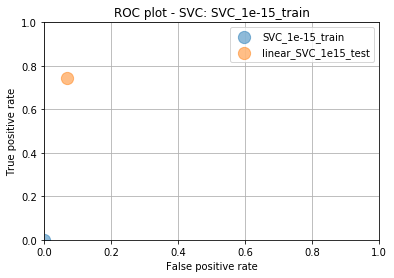

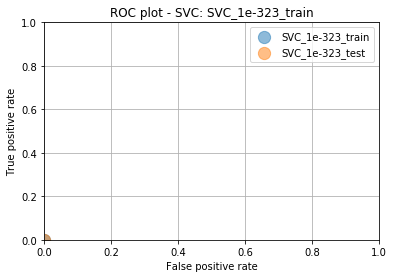

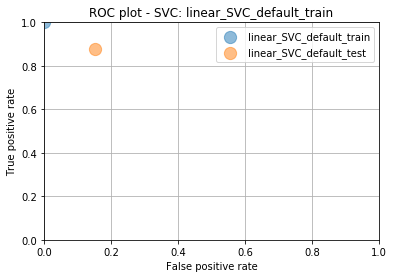

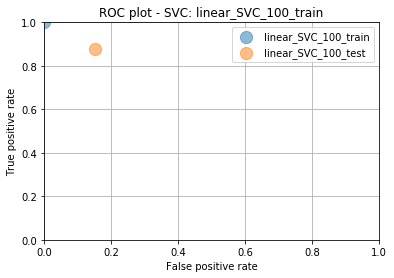

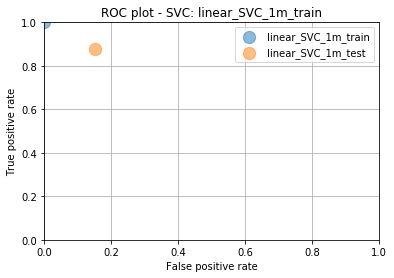

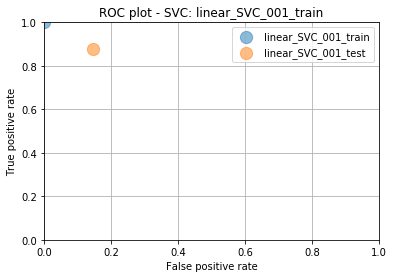

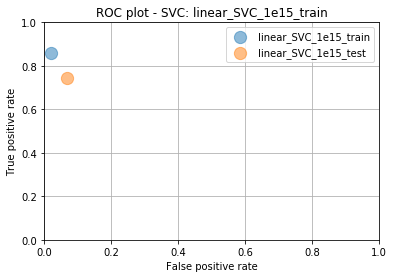

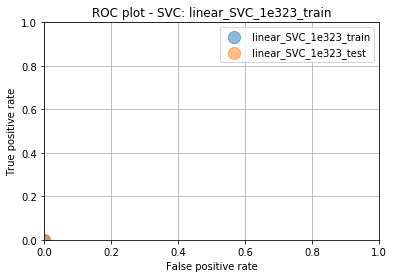

In [35]:
# create the ROC plots for all iterations
for iteration in all_iterations:
    title=iteration[0].performance_measures['desc'].replace("svc_train_", 'alpha_').replace('.','-')
    create_ROC_rgd(iteration, title)

In [36]:
def plot_iterations(fits, title, image_name, limits=False):
    # plots the performance of all models - runs twice below: once for train set and once for test set performance
    
    N = len(fits)
    x = [] # for each fit - fit.performance_measures['FP'] / fit.performance_measures['Neg']
    y = [] # for each fit - fit.performance_measures['TP'] / fit.performance_measures['Pos']

    for fit in fits:
        x.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
        y.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])


    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(N)]
    area = 150

    fig, ax = plt.subplots()
    
    ax.grid(True)
    
    for fit in fits:
        index = fits.index(fit)
        color=colors[index]
        ax.scatter(x, y, s=area, c=color, label=fit.desc, alpha=0.5)

    if limits == True:
        # make axes 0 to 1
        ax.set_xlim(left=-0.1)
        ax.set_xlim(right=1.1)
        ax.set_ylim(bottom=0)
        ax.set_ylim(top=1.1)
    
    plt.legend()
    plt.title(title)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    img_path = 'plot_images/03/' + image_name + '_all' + '.png'
    
    fig.savefig(img_path, dpi=fig.dpi)

## Plots

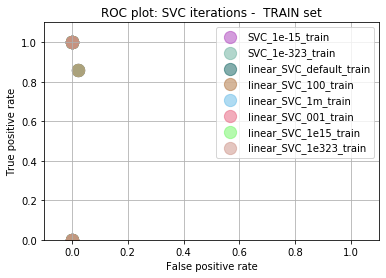

In [37]:
plot_iterations(fits_train, 'ROC plot: SVC iterations -  TRAIN set', 'SVC_train_iterations', limits=True)


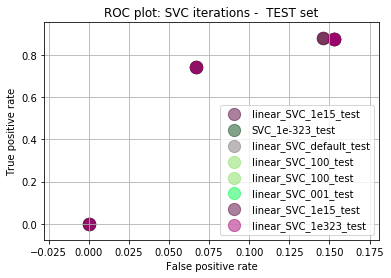

In [38]:
plot_iterations(fits_test, 'ROC plot: SVC iterations -  TEST set', 'svc_test_iterations')


## Compare training VS test set performance

In [39]:
# shorten description to show alpha value only - train sets
for fit in fits_train:
    fit.performance_measures['desc'] = fit.performance_measures['desc'].replace('linear_SVC_', 'L_')
    print(fit.performance_measures['desc'])

SVC_1e-15_train
SVC_1e-323_train
L_default_train
L_100_train
L_1m_train
L_001_train
L_1e15_train
L_1e323_train


In [40]:
# shorten description to show alpha value only - test sets
for fit in fits_test:
    print(fit.performance_measures['desc'])
    fit.performance_measures['desc'] = fit.performance_measures['desc'].replace('linear_SVC_', 'L_')
    print(fit.performance_measures['desc'])

linear_SVC_1e15_test
L_1e15_test
SVC_1e-323_test
SVC_1e-323_test
linear_SVC_default_test
L_default_test
linear_SVC_100_test
L_100_test
L_100_test
L_100_test
linear_SVC_001_test
L_001_test
L_1e15_test
L_1e15_test
linear_SVC_1e323_test
L_1e323_test


SVC_1e-15_train
SVC_1e-323_train
L_default_train
L_100_train
L_1m_train
L_001_train
L_1e15_train
L_1e323_train


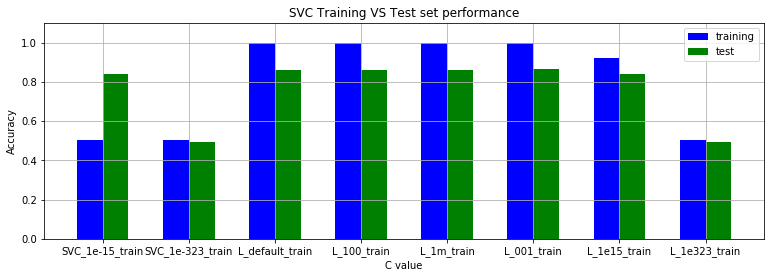

In [41]:
# Grouped bar chart comparing the accuracy of each model - training and test set
accuracy_train = []
description = []
for fit in fits_train:
    print(fit.performance_measures['desc'])
    accuracy_train.append(fit.performance_measures['Accuracy'])
    description.append(fit.performance_measures['desc'])
    
accuracy_test = []
for fit in fits_test:
    accuracy_test.append(fit.performance_measures['Accuracy'])

width = 0.3
x = np.arange(len(description))

fig = plt.figure(figsize=[10, 3])
ax = fig.add_axes([0,0,1,1])

plt.grid()

ax.bar(x, accuracy_train, color='b', width=width, label="training")
ax.bar(x + width, accuracy_test, color='g', width=width, label="test")

ax.set_ylabel('Accuracy')
ax.set_xlabel('C value')

ax.set_title('SVC Training VS Test set performance')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(description)
ax.legend()


# make axes 0 to 1
ax.set_ylim(bottom=0)
ax.set_ylim(top=1.1)

title = 'train_test_bars'

image_path = 'plot_images/03/' + title + '_accuracy' + '.png'
fig.savefig(image_path, dpi=fig.dpi)

plt.show()

SVC_1e-15_train
SVC_1e-323_train
L_default_train
L_100_train
L_1m_train
L_001_train
L_1e15_train
L_1e323_train


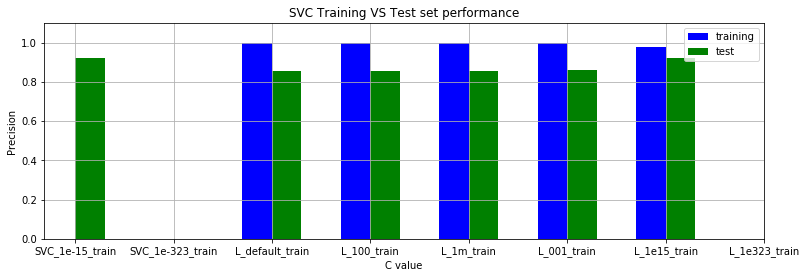

In [42]:
# Grouped bar chart comparing the precision of each model - training and test set
precision_train = []
description = []
for fit in fits_train:
    print(fit.performance_measures['desc'])
    precision_train.append(fit.performance_measures['Precision'])
    description.append(fit.performance_measures['desc'])
    
precision_test = []
for fit in fits_test:
    precision_test.append(fit.performance_measures['Precision'])

width = 0.3
x = np.arange(len(description))

fig = plt.figure(figsize=[10, 3])
ax = fig.add_axes([0,0,1,1])

plt.grid()

ax.bar(x, precision_train, color='b', width=width, label="training")
ax.bar(x + width, precision_test, color='g', width=width, label="test")

ax.set_ylabel('Precision')
ax.set_xlabel('C value')

ax.set_title('SVC Training VS Test set performance')

ax.set_xticks(x + width / 2)
ax.set_xticklabels(description)
ax.legend()


# make axes 0 to 1
ax.set_ylim(bottom=0)
ax.set_ylim(top=1.1)

title = 'train_test_bars'

image_path = 'plot_images/03/' + title + '_precision' + '.png'
fig.savefig(image_path, dpi=fig.dpi)

plt.show()